In [8]:
ALPHA =  50.0

# Ridge Regression - some Theory

* Todo

# Get the data

In [9]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
Supervised = namedtuple("supervised", ["features", "target", "feature_names"])

def split_test_train(data):
    X_train, X_test, Y_train, Y_test = train_test_split(data.features, data.target, test_size = 0.2, random_state=5)
    train = Supervised(X_train, Y_train.reshape(-1, 1), feature_names=data.feature_names)
    test = Supervised(X_test, Y_test.reshape(-1, 1), feature_names=data.feature_names)
    return train, test 


def normalize(train: Supervised, test: Supervised):
    mu = train.features.mean(axis=0)
    std = train.features.std(axis=0)
    train_scaled = Supervised(features=(train.features - mu) / std, 
                              target=train.target, 
                              feature_names=train.feature_names) 
    test_scaled = Supervised(features=(test.features - mu) / std, 
                             target=test.target, 
                             feature_names=test.feature_names)
    return train_scaled, test_scaled


housing = fetch_california_housing()
train_data, test_data = normalize(*split_test_train(Supervised(housing.data, housing.target, housing.feature_names)))

# Ridge Regression via the Normal equation - with Tensorflow

In [10]:
def add_intercept(features):
    """Add intercept to features
    Todo: as an exercise use tensorflow"""
    m, n = features.shape
    return np.c_[np.ones((m, 1)), features]

    
def train(data, alpha):
    X = add_intercept(data.features)
    Y = data.target
    XT = tf.transpose(X)
    cov = tf.matmul(XT, X)
    one = tf.eye(cov.shape[0], dtype=tf.dtypes.float64)
    inv = tf.linalg.inv(cov + alpha * one)
    return tf.matmul(tf.matmul(inv, XT), Y)


def predict(data, theta):
    return tf.matmul( add_intercept(data.features),  theta)

theta_analytic = train(train_data, ALPHA)
y_pred_analytic  = predict(test_data, theta_analytic)

# Ridge Regression as a Neural Network with Tensorflow / Keras 
* Idea: use keras wit 1 layer, identitiy as activation function
* Assume that we could not find the minimizer analytically. 
* Thus we wish to find the minimzer computationally.

> **Note** the accuracy with an explicit optimizier critically hinges on the convergence behaviour of the optimizer.  In this case wie use the Adam optimizer with learning rate = 0.01. It's instructive to break the model by employing a non-convergent optimizer (e.g. RSMprops with learnin rate 0.01 for this particular case).

In [49]:
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd


def plot_keras_training(history):
    plt.figure(figsize=(15,4))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot({'Basic': history}, metric = "mse")
    #plt.ylim([0, 3])
    plt.xlim([0,30])
    plt.ylabel('MSE')
    plt.show()

def build_model():
    """Regularization via kernel and bias regularizer
    Todo: via loss 
    """
    model = keras.Sequential([layers.Dense(1, 
                                           activation='linear', 
                                           input_shape=[8],
                                           kernel_regularizer=(regularizers.l2(ALPHA)) , 
                                           bias_regularizer=regularizers.l2(ALPHA))])
    #optimizer = tf.keras.optimizers.Adam(0.001)
    optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model

model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [50]:
EPOCHS = 200

history = model.fit(
  train_data.features, train_data.target,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:6.7038,  mse:5.4377,  val_loss:5.4297,  val_mse:5.3289,  
....................................................................................................
Epoch: 100, loss:5.4968,  mse:5.3996,  val_loss:5.4302,  val_mse:5.3299,  
....................................................................................................

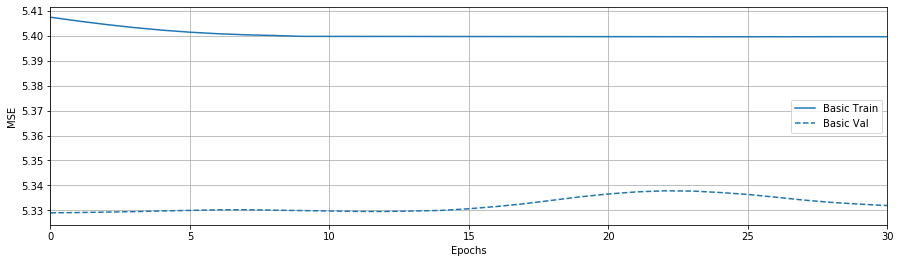

In [51]:
plot_keras_training(history)

In [52]:
theta_keras = tf.concat((model.weights[1], tf.reshape(model.weights[0], [8])), axis=0)
y_pred_keras = model.predict(test_data.features)

# Linear Regression using the estimator API
* within the estimator API the number of training steps is controlled via the the `dataset`
* more precisely via the `repeat` keyword

In [7]:
from tensorflow.estimator import LinearRegressor
from tensorflow import feature_column

In [8]:
def input_fn(data: Supervised, train=False):
    """Todo: make callable class for more intuitive usage lateron"""
    raw_xs = pd.DataFrame(data.features, columns = data.feature_names)
    xs = {key:np.array(value) for key,value in dict(raw_xs).items()} 
    ys = data.target
    ds = tf.data.Dataset.from_tensor_slices((xs, ys)).batch(raw_xs.shape[0])
    if train:
        return ds.repeat(200)
    return ds

In [4]:
"""
feature_columns = [feature_column.numeric_column(f) for f in housing.feature_names]
linear_regressor = LinearRegressor(feature_columns=feature_columns)
linear_regressor.train(lambda: input_fn(train_data, train=True))
y_pred_estimator = np.array([r["predictions"] for r in linear_regressor.predict(lambda: input_fn(test_data, train=False))])
"""

'\nfeature_columns = [feature_column.numeric_column(f) for f in housing.feature_names]\nlinear_regressor = LinearRegressor(feature_columns=feature_columns)\nlinear_regressor.train(lambda: input_fn(train_data, train=True))\ny_pred_estimator = np.array([r["predictions"] for r in linear_regressor.predict(lambda: input_fn(test_data, train=False))])\n'

# Sklearn 

In [26]:
# For comparison perform linear regression with scikit learn
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

lin_model = Ridge(alpha=ALPHA, fit_intercept=True, normalize=False)
lin_model.fit(train_data.features, train_data.target)
theta_sklearn = tf.concat((lin_model.intercept_, lin_model.coef_.flatten()), axis=0)
y_pred_sklearn = lin_model.predict(test_data.features)

# Comparision of results

In [30]:
def mse(y_true, y_pred):
    return tf.reduce_sum((y_true - y_pred)**2) / y_true.shape[0]

In [31]:
mse(test_data.target,  y_pred_sklearn) 

<tf.Tensor: shape=(), dtype=float64, numpy=0.536374031056514>

In [45]:
mse(test_data.target,  y_pred_analytic) 

<tf.Tensor: shape=(), dtype=float64, numpy=0.53659121216352>

In [55]:
mse(test_data.target,  y_pred_keras)

<tf.Tensor: shape=(), dtype=float64, numpy=5.5508056220697695>

In [16]:
mse(test_data.target,  y_pred_estimator) 

<tf.Tensor: shape=(), dtype=float64, numpy=0.5364407506165265>

In [17]:
y_pred_keras.shape

(4128, 1)

In [18]:
y_pred_estimator.shape

(4128, 1)

In [19]:
theta_sklearn

<tf.Tensor: shape=(9,), dtype=float64, numpy=
array([ 2.06389635,  0.82789366,  0.11540032, -0.2811675 ,  0.32431215,
       -0.00344465, -0.04502135, -0.89616073, -0.86808269])>

In [46]:
theta_sklearn

<tf.Tensor: shape=(9,), dtype=float64, numpy=
array([ 2.06389635e+00,  8.25666498e-01,  1.19237056e-01, -2.71852126e-01,
        3.12678866e-01, -2.05983426e-03, -4.52431646e-02, -8.59902178e-01,
       -8.31381824e-01])>

In [53]:
theta_keras

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 3.9051950e-02,  1.2369652e-02,  9.1402984e-04,  3.9863731e-03,
       -9.2467380e-05,  6.6892453e-04,  3.0635493e-03, -2.2308654e-03,
       -1.2616077e-03], dtype=float32)>

In [54]:
theta_analytic

<tf.Tensor: shape=(9, 1), dtype=float64, numpy=
array([[ 2.05766553],
       [ 0.8256665 ],
       [ 0.11923706],
       [-0.27185213],
       [ 0.31267887],
       [-0.00205983],
       [-0.04524316],
       [-0.85990218],
       [-0.83138182]])>